# Artificial Neural Networks

In [1]:
import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score,f1_score


#Set figure size
sns.set(rc={'figure.figsize':(8,10)})

#Load data
df = pd.read_csv(os.path.join('data','data_filtered.csv'))
df2  = pd.read_csv(os.path.join('data','data_all.csv'))

#Enable CUDA
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

df

,sd,Q25,IQR,sp.ent,sfm,meanfun,mindom,dfrange,label
0,0.241585,0.455971,-0.601712,0.796058,0.925288,1.302489,-0.708404,-0.415794,1
1,-0.114476,-0.105393,0.401743,0.461699,-0.229014,-0.259737,-0.461523,0.412186,0
2,-1.284107,1.726540,-1.169425,-1.599113,-1.269425,1.315527,-0.461523,1.777355,1
3,1.089943,-0.391539,0.786946,0.578250,0.982092,-0.698228,-0.708404,-0.679948,0
4,0.231523,0.681061,-0.527833,0.508050,0.516462,1.167348,-0.708404,-1.343664,1
...,...,...,...,...,...,...,...,...,...
3163,1.087355,-0.480803,0.982768,1.385949,1.667369,-0.969765,-0.338082,-1.208257,0
3164,-1.471392,0.863030,-1.176833,-0.555301,-1.128432,0.530223,1.143207,-1.214917,1
3165,0.644400,-0.395149,0.953317,0.626947,0.305185,-0.983770,-0.708404,-0.688828,0
3166,1.557415,-0.558784,0.970942,1.076622,1.232644,-0.441604,-0.708404,-0.005133,0


Transforming the data into PyTorch Tensors

In [2]:
# df = df.drop(['Q25','IQR','sp.ent','meanfun','mindom'],axis=1)


feature_size = len(df.drop(['label'],axis=1).columns)
print(f'Number of Features: {feature_size}')



train_x, test_x, train_y, test_y = train_test_split(
    df.drop(['label'], axis=1), df['label'], test_size=0.2, random_state=42)


train_x = torch.tensor(train_x.values,
                      dtype=torch.float32, device=device)
train_y = torch.tensor(train_y.to_frame().values,
                      dtype=torch.float32, device=device)

test_x = torch.tensor(test_x.values,
                      dtype=torch.float32, device=device)
test_y = torch.tensor(test_y.to_frame().values,
                      dtype=torch.float32, device=device)

Number of Features: 8


In [20]:
class Model(torch.nn.Module):
    def __init__(self,
                 input_size: int,  # Number of features
                 num_classes: int,  # Number of classes
                 hidden: int,      # Number of hidden layers
                 hidden_size: list,  # Sizes of the hidden layers in sequential order
                 activation: str,  # The activation function
                 ):
        super().__init__()

        assert(hidden == len(hidden_size) and hidden >= 0)

        # Activation function
        if activation == 'relu':
            self.activate = torch.nn.ReLU()
        if activation == 'leaky_relu':
            self.activate = torch.nn.LeakyReLU()
        if activation == 'sigmoid':
            self.activate = torch.nn.Sigmoid()
        if activation == 'tanh':
            self.activate = torch.nn.Tanh()
        
        #No Hidden Layers
        if hidden == 0:
            _layers = [torch.nn.Linear(
                input_size, num_classes, device=device)]
        
        #Yes Hidden Layers
        else:
            # Input Layer
            _layers = [torch.nn.Linear(
                input_size, hidden_size[0], device=device)]

            # For every hidden layer pair
            for i in range(1, hidden):

                _layers.append(
                    torch.nn.Linear(hidden_size[i-1],
                                    hidden_size[i], device=device))

            # Output layer
            _layers.append(torch.nn.Linear(hidden_size[hidden-1],
                                           num_classes, device=device))

        # Convert to Parameter list, to be accessible by optimiser
        self.layers = torch.nn.ParameterList(_layers)

    def forward(self, x):
        out = self.layers[0](x)

        for layer in self.layers[1:]:
            out = self.activate(out)
            out = layer(out)

        return out  # Return logits

    def train(self, train_x, train_y,
              epochs, interval=100):

        # Initalise optimiser

        # optimiser = torch.optim.SGD(model.parameters(),lr=0.1)
        optimiser = torch.optim.Adam(model.parameters())

        history = []  # Save error loss over time

        # Training loop
        for step in range(1, epochs+1):

            # Train
            optimiser.zero_grad()
            output = self(train_x)
            error = torch.nn.functional.binary_cross_entropy_with_logits(
                output, train_y)
            error.backward()
            optimiser.step()

            # Print to standard output
            if interval > 0 and step % interval == 0:
                print(step, error.detach().tolist())
                history.append((step, error.tolist()))

        return pd.DataFrame(history, columns=['Epoch', 'Train Loss'])

    def test(self, test_x, test_y):
        error = []
        with torch.no_grad():
            outputs = torch.sigmoid(self(test_x))
            for (x, pred, actual) in zip(test_x, outputs, test_y):
                error.append(
                    torch.nn.functional.binary_cross_entropy(
                        pred, actual)
                )
        return error

    def train_and_test(self, train_x, train_y, test_x, test_y,
                       epochs, interval=1000, trace=False, early_stopping=False):

        # Initialise optimiser
        optimiser = torch.optim.Adam(model.parameters())

        history = []  # Save error loss over time

        # Training and testing loop
        for step in range(1, epochs+1):

            # Train
            optimiser.zero_grad()
            output = self(train_x)
            error = torch.nn.functional.binary_cross_entropy_with_logits(
                output, train_y)
            error.backward()
            optimiser.step()

            # Calculate test error every interval and save to history
            if interval > 0 and step % interval == 0:
                # Test
                test_error = 0

                with torch.no_grad():
                    outputs = torch.sigmoid(self(test_x))
                    # Calculate average error over test set
                    for (x, pred, actual) in zip(test_x, outputs, test_y):
                        test_error += torch.nn.functional.binary_cross_entropy(
                            pred, actual)

                avg_test_error = test_error/len(test_x)

                # Print current error to stdout
                if trace:
                    print(step, error.detach().tolist())

                # Track loss over time
                history.append(
                    (step, error.tolist(), avg_test_error.tolist()))

                #Model is overfitting
                if early_stopping and \
                        error.tolist() < avg_test_error.tolist():

                    print('Overfitting: Performing early stopping')
                    break

        return pd.DataFrame(history, columns=['Epoch', 'Train Loss', 'Test Loss'])

In [4]:
def run(model: torch.nn.Module):
    
    # Training and testing
    history = model.train_and_test(train_x, train_y, test_x, test_y,
                                   interval=250, epochs=6000, early_stopping=True)

    #Plot error loss
    fig, (ax1,ax2) = plt.subplots(2,1)
    sns.lineplot(data=history, x='Epoch', y='Train Loss',ax=ax1)
    sns.lineplot(data=history, x='Epoch', y='Test Loss' ,ax=ax1)

    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('$E$')
    
    #Get outputs from model
    with torch.no_grad():    
        outputs = torch.flatten(torch.sigmoid(model(test_x))).tolist()
    
    #Round to nearest integer -> [0,1]
    prediction = list(map(round,outputs))
    
    #Get actual output
    actual = torch.flatten(test_y).tolist()   

    #Generate confusion matrix
    cm = confusion_matrix(actual, prediction)
    count      = ["{0:0.0f}".format(v) for v in cm.flatten()]
    percentage = ["{0:.2%}".format(v) for v in cm.flatten()/np.sum(cm)]
    labels = np.asarray([f"{v1}\n{v2}" for v1, v2 in
              zip(count,percentage)]).reshape(2,2)
    sns.heatmap(cm,fmt='',annot=labels,ax=ax2)
    
    #Generate Accuracy, Precision, Recall, F1 Score   
    print('Accuracy:\t%.3f'% accuracy_score(prediction, actual))
    print('Precision:\t%.3f'% precision_score(prediction, actual))
    print('Recall:  \t%.3f'% recall_score(prediction, actual))
    print('F1 Score:\t%.3f'% f1_score(prediction, actual))
    
    print()
    
    plt.show()

# Experimenting with different hyper parameters

## Using the filtered dataset

### Different Hidden Layer Sizes

#### Using No Hidden Layers

Accuracy:	0.976
Precision:	0.968
Recall:  	0.984
F1 Score:	0.976



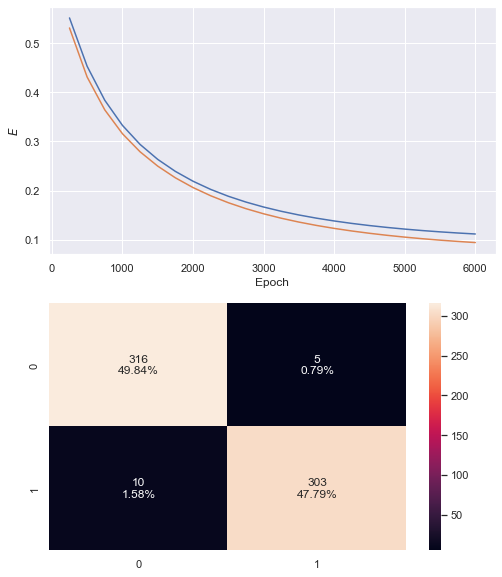

In [5]:
#No Hidden Layers
model = Model(input_size=feature_size,
              num_classes=1,
              hidden=0, hidden_size=[],
              activation='relu')
model.to(device)

run(model)

#### Using 1 Hidden Layer

Overfitting: Performing early stopping
Accuracy:	0.987
Precision:	0.987
Recall:  	0.987
F1 Score:	0.987



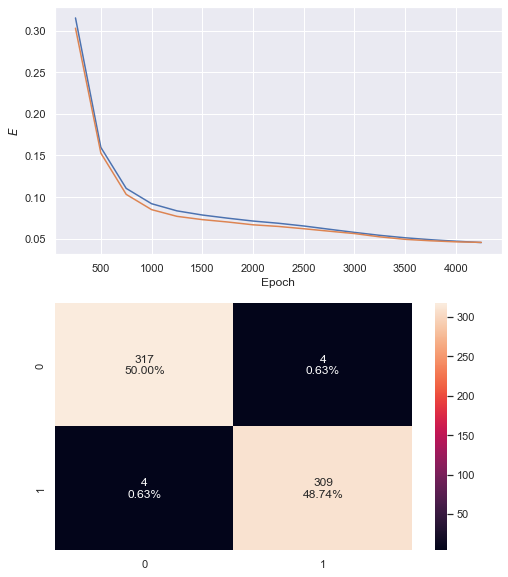

In [6]:
#8 Neurons
model = Model(input_size=feature_size,
              num_classes=1,
              hidden=1, hidden_size=[8],
              activation='relu')
model.to(device)

run(model)

Overfitting: Performing early stopping
Accuracy:	0.983
Precision:	0.987
Recall:  	0.978
F1 Score:	0.983



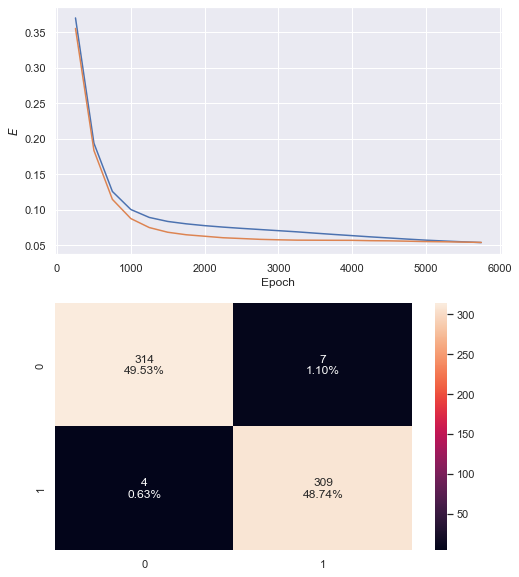

In [7]:
#6 Neurons
model = Model(input_size=feature_size,
              num_classes=1,
              hidden=1, hidden_size=[6],
              activation='relu')
model.to(device)

run(model)

Accuracy:	0.973
Precision:	0.974
Recall:  	0.971
F1 Score:	0.973



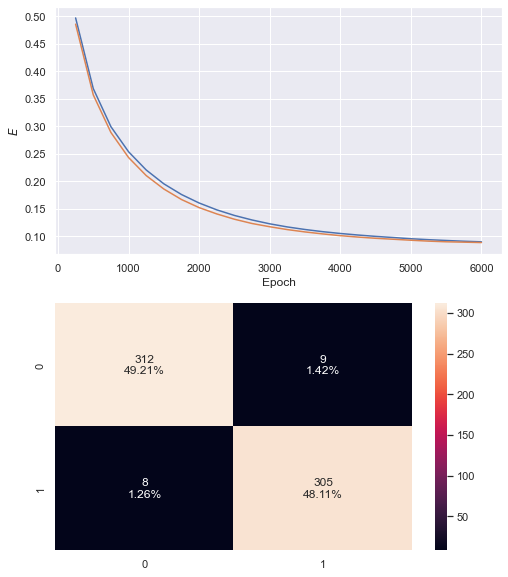

In [8]:
#4 neurons
model = Model(input_size=feature_size,
              num_classes=1,
              hidden=1, hidden_size=[4],
              activation='relu')
model.to(device)

run(model)

Accuracy:	0.978
Precision:	0.978
Recall:  	0.978
F1 Score:	0.978



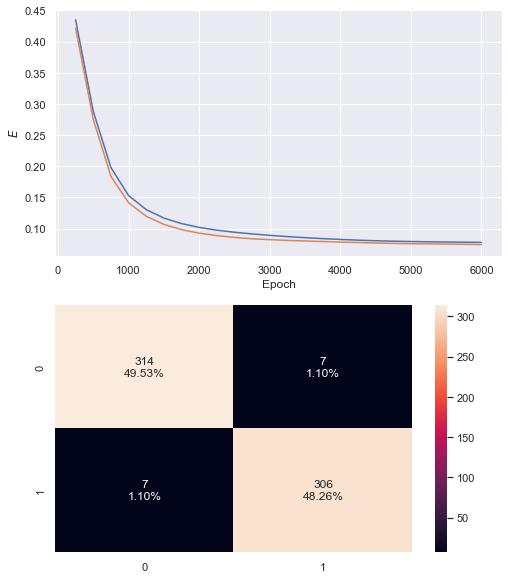

In [9]:
#2 Neurons
model = Model(input_size=feature_size,
              num_classes=1,
              hidden=1, hidden_size=[2],
              activation='relu')
model.to(device)

run(model)

Accuracy:	0.978
Precision:	0.971
Recall:  	0.984
F1 Score:	0.977



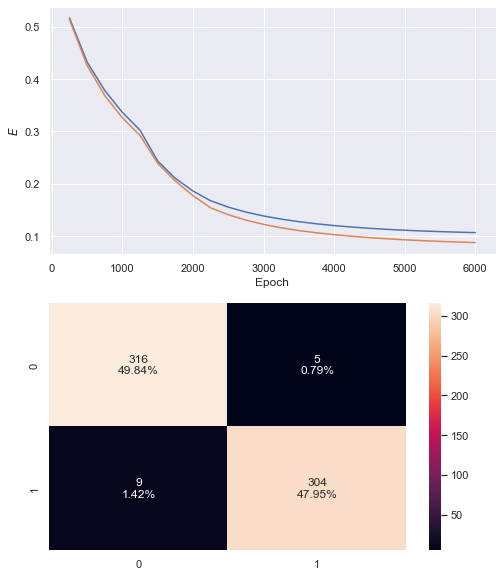

In [10]:
#1 Neuron
model = Model(input_size=feature_size,
              num_classes=1,
              hidden=1, hidden_size=[1],
              activation='relu')
model.to(device)

run(model)

#### Using 2 Hidden Layers

Overfitting: Performing early stopping
Accuracy:	0.986
Precision:	0.987
Recall:  	0.984
F1 Score:	0.986



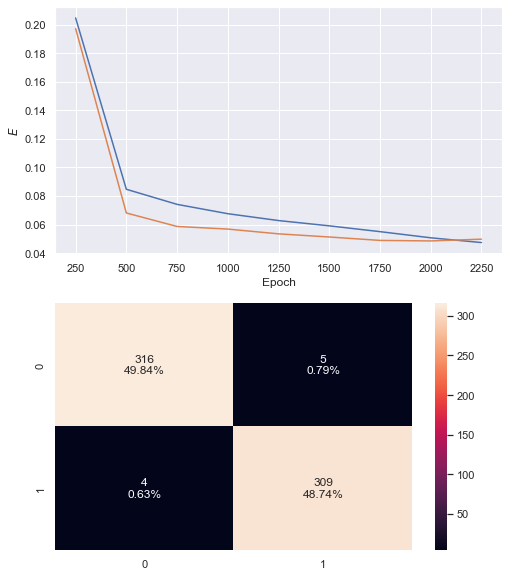

In [11]:
#8x8
model = Model(input_size=feature_size,
              num_classes=1,
              hidden=2, hidden_size=[8,8],
              activation='relu')
model.to(device)

run(model)

Overfitting: Performing early stopping
Accuracy:	0.984
Precision:	0.984
Recall:  	0.984
F1 Score:	0.984



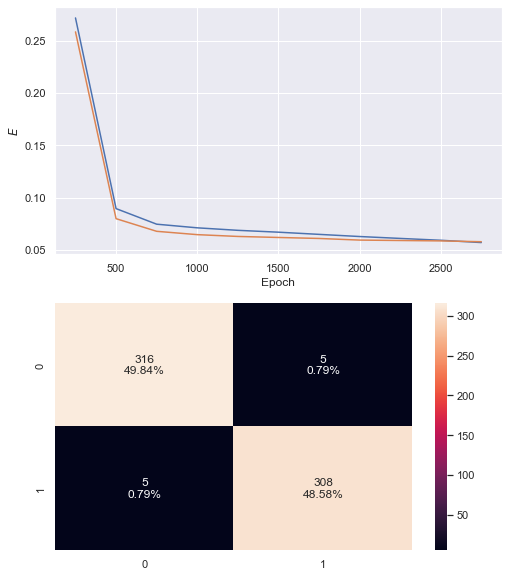

In [12]:
#8x6
model = Model(input_size=feature_size,
              num_classes=1,
              hidden=2, hidden_size=[8,6],
              activation='relu')
model.to(device)

run(model)

Overfitting: Performing early stopping
Accuracy:	0.981
Precision:	0.987
Recall:  	0.975
F1 Score:	0.981



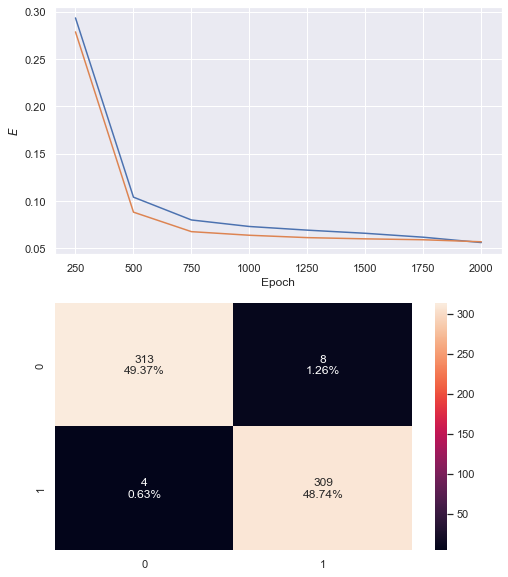

In [13]:
#6x6
model = Model(input_size=feature_size,
              num_classes=1,
              hidden=2, hidden_size=[6,6],
              activation='relu')
model.to(device)

run(model)

Accuracy:	0.978
Precision:	0.971
Recall:  	0.984
F1 Score:	0.977



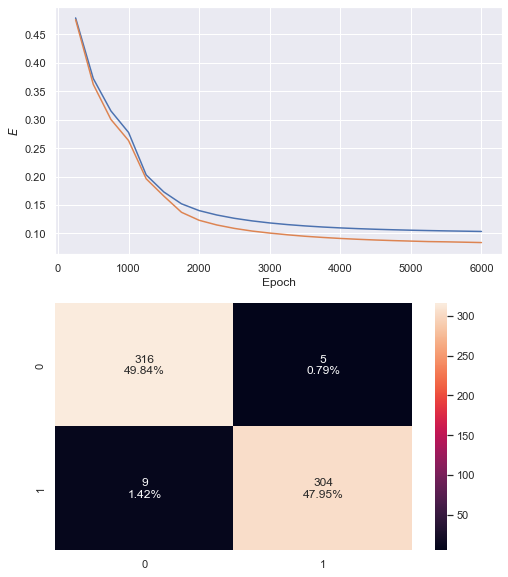

In [14]:
#1x1
model = Model(input_size=feature_size,
              num_classes=1,
              hidden=2, hidden_size=[1,1],
              activation='relu')
model.to(device)

run(model)

### Using Different Activation Functions

#### One Hidden Layer of 8 Neurons

Overfitting: Performing early stopping
Accuracy:	0.986
Precision:	0.987
Recall:  	0.984
F1 Score:	0.986



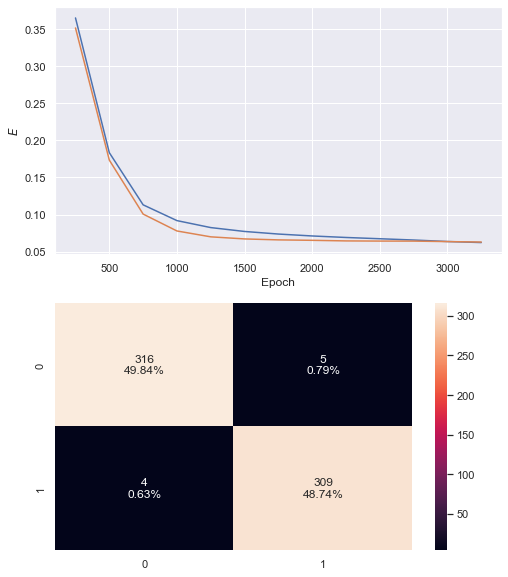

In [15]:
#Using ReLU
model = Model(input_size=feature_size,
              num_classes=1,
              hidden=1, hidden_size=[8],
              activation='relu')
model.to(device)

run(model)

Overfitting: Performing early stopping
Accuracy:	0.984
Precision:	0.981
Recall:  	0.987
F1 Score:	0.984



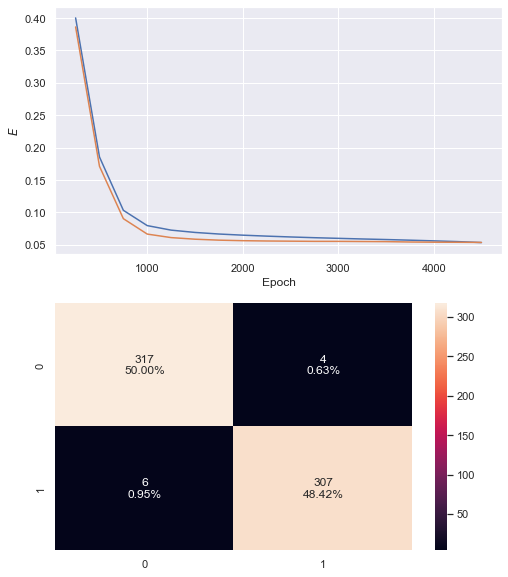

In [16]:
#Using Leaky ReLU
model = Model(input_size=feature_size,
              num_classes=1,
              hidden=1, hidden_size=[8],
              activation='leaky_relu')
model.to(device)

run(model)

Accuracy:	0.981
Precision:	0.978
Recall:  	0.984
F1 Score:	0.981



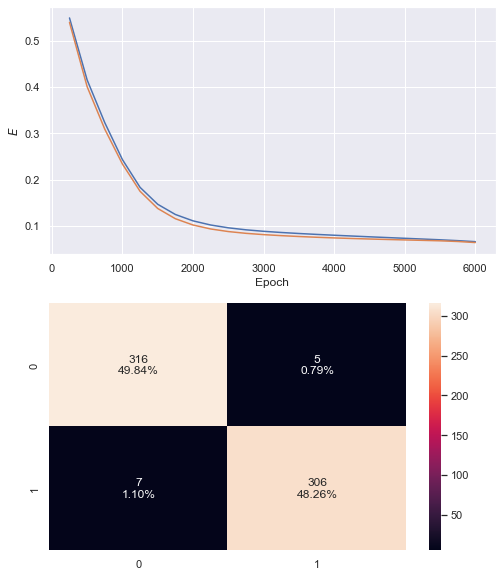

In [17]:
#Using Sigmoid
model = Model(input_size=feature_size,
              num_classes=1,
              hidden=1, hidden_size=[8],
              activation='sigmoid')
model.to(device)

run(model)

Overfitting: Performing early stopping
Accuracy:	0.979
Precision:	0.974
Recall:  	0.984
F1 Score:	0.979



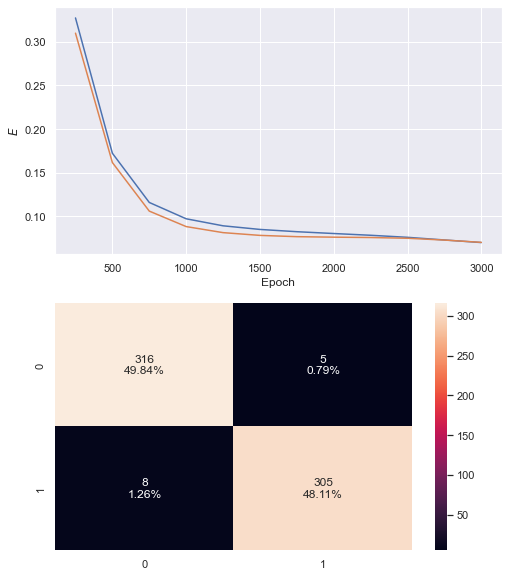

In [21]:
#Using TanH
model = Model(input_size=feature_size,
              num_classes=1,
              hidden=1, hidden_size=[8],
              activation='tanh')
model.to(device)

run(model)